In [106]:
#see https://subscription.packtpub.com/book/application-development/9781783984985/4/ch04lvl1sec75/converting-a-map-coordinate-to-a-pixel-location

from osgeo import gdal

def world2Pixel(geoMatrix, x, y):
  ulX = geoMatrix[0]
  ulY = geoMatrix[3]
  xDist = geoMatrix[1]
  yDist = geoMatrix[5]
  rtnX = geoMatrix[2]
  rtnY = geoMatrix[4]
  pixel = int((x - ulX) / xDist)
  line = int((y - ulY) / yDist)
  return (pixel, line)

src = gdal.Open("wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-01.tif")

geoTrans = src.GetGeoTransform()

world2Pixel(geoTrans, 87.42445, 48.57034)

#arrays to use for input data
Precip = []
T_air = []
SWE = [0]

In [108]:
# https://gis.stackexchange.com/questions/346288/extract-all-pixels-values-from-geotiff-with-python

import rasterio
import random

p_data = ['wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-10.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-11.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-12.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-01.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-02.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-03.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-04.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-05.tif']

t_data = ['wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-10.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-11.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-12.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-01.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-02.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-03.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-04.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-05.tif']

d_data = [31,30,31,31,28,31,30,31] #number of days in each month

band_id = 1  # this assumes you want the first band, change to match the band number you want

for i in range(0, len(p_data)):

    #need to allocate the monthly data to the number of days in the month
    num_days = int(d_data[i])

    raster = rasterio.open(p_data[i])
    band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)

    precip_value = band_arr[994, 6418]

    raster = rasterio.open(t_data[i])
    band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)

    tmax_value = band_arr[994, 6418]

    for i in range(0, num_days):
        if(random.randint(0,100) < 40):
            Precip.append(0)
        else:
            Precip.append(precip_value/num_days * (1 + float(random.randint(-60, 100))/100.0))

    for i in range(0, num_days):
        T_air.append(tmax_value + float(random.randint(-70, 71))/10.0)

    for i in range(0, num_days):
        SWE.append(0)


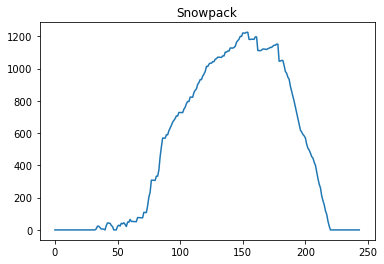

In [109]:
# see: https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides/modeling-snowmelt/using-the-snowmelt-modeling-capabilities-within-hec-hms

import matplotlib.pyplot as plt

#calculate snowpack based on weather data

# dSWE = P - R + V + B, where:

# d = change in
# SWE = Snow Water Equivalent
# P = Precipitation contribution (see rain-to-snow multiplier table below)
# R = Run off (determined by phase change in the snowpack which is determined through the energy balance calculations)
# V = mass gained by water Vapor (can be negative)
# B = mass gained by Blowing snow (can be negative)

# The melt rate for dry conditions typically ranges from 1 to 4 mm/degC-day

rain_to_snow = [
   #Tmin, Tmax, multiplier 
    [1, 40, 0],
    [-2.8, 1, 10],
    [-6.7, -2.8, 15],
    [-9.5, -6.7, 20],
    [-12.2, -9.5, 30],
    [-17.8, -12.2, 40],
    [-28.9, -17.8, 50],
    [-60, -28.9, 100]]

for i in range(0, len(Precip)):
    
    P = Precip[i]
    
    for r in range(0, len(rain_to_snow)):
        if (T_air[i] >= rain_to_snow[r][0]):
            if (T_air[i] < rain_to_snow[r][1]):
                P = Precip[i]*rain_to_snow[r][2]
    
    R = 0
    if T_air[i] > 0:
        if P == 0:
            R = T_air[i] * 2.5
        else:
            R = T_air[i] * 200.0
    else:
        R = 0.5

    SWE[i+1] = SWE[i] + P - R
    
    if(SWE[i+1] < 0):
        SWE[i+1] = 0

#plot the stock's performance
plt.plot(SWE)
plt.title('Snowpack')

plt.show()

In [99]:
#ground truthing the snowpack model at Paradise, Washington (-121.734973, 46.785316)
#see: https://wcc.sc.egov.usda.gov/nwcc/rgrpt?report=temperature_avg_hist&state=WA

import pandas as pd

#daily average air temperature by year
t_data = pd.read_csv('temperature-paradise.csv', sep=",")
#t_data = pd.Series(temp)

#daily accumulated precipitation temperature by year
p_data = pd.read_csv('accumulated_precip-paradise.csv', sep=",")

#daily accumulated precipitation temperature by year
s_data = pd.read_csv('snowpack-paradise.csv', sep=",")

d_data = [31,30,31,31,29,31,30,31] #number of days in each month (Oct -> May)
m_name = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

#arrays to use for input data
APrecip = []
Precip = []
T_air = []
SWE = [0]
Snowpack = []

for i in range(0, len(d_data)):
    t = t_data[m_name[i]]
    p = p_data[m_name[i]]
    s = s_data[m_name[i]]
    for j in range(0, d_data[i]):
        T_air.append(int(t[j:j+1]-32)/1.8) #convert deg-F to deg-C
        APrecip.append(float(p[j:j+1]))
        Snowpack.append(float(s[j:j+1])*12) #convert feet to inches
        SWE.append(0)
        
#convert accumulated precipitation to daily
Precip.append(APrecip[0])
for i in range(1, len(APrecip)):
    Precip.append(APrecip[i]-APrecip[i-1])
    

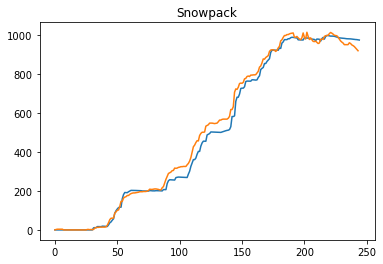

In [132]:
# see: https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides/modeling-snowmelt/using-the-snowmelt-modeling-capabilities-within-hec-hms

import matplotlib.pyplot as plt

#calculate snowpack based on weather data

# dSWE = P - R + V + B, where:

# d = change in
# SWE = Snow Water Equivalent
# P = Precipitation contribution (see rain-to-snow multiplier table below)
# R = Run off (determined by phase change in the snowpack which is determined through the energy balance calculations)
# V = mass gained by water Vapor (can be negative)
# B = mass gained by Blowing snow (can be negative)

# The melt rate for dry conditions typically ranges from 0.039 to 0.15748 inch/degC-day

rain_to_snow = [
   #Tmin, Tmax, multiplier 
    [0, 40, 0],
    [-2.8, 1, 12],
    [-6.7, -2.8, 18],
    [-9.5, -6.7, 25],
    [-12.2, -9.5, 30],
    [-17.8, -12.2, 40],
    [-28.9, -17.8, 50],
    [-60, -28.9, 100]]

for i in range(0, len(Precip)):
    
    P = Precip[i]
    
    for r in range(0, len(rain_to_snow)):
        if (T_air[i] >= rain_to_snow[r][0]):
            if (T_air[i] < rain_to_snow[r][1]):
                P = Precip[i]*rain_to_snow[r][2]
    
    R = 0
    if T_air[i] > 0:
        if P == 0:
            R = T_air[i] * 0.15748
        else:
            R = T_air[i] * 20.0
    else:
        R = 0.1

    SWE[i+1] = (SWE[i] + P - R)
    
    if(SWE[i+1] < 0):
        SWE[i+1] = 0

#plot the outputs
plt.plot(SWE)
plt.plot(Snowpack)
#plt.plot(T_air)
plt.title('Snowpack')

plt.show()
